## Importing Libraries

In [42]:
# !pip install cufflinks

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ML Libraries

from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.utils import shuffle

import plotly.figure_factory as ff
import plotly.offline as py 
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools 
py.init_notebook_mode (connected = True)

import cufflinks as cf
cf.go_offline()

## Disable Warnings

In [2]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

## Loading the data

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv("fuel.csv")

dataset = raw_dataset.copy()
dataset.tail()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
393,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
395,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
396,28.0,4,120.0,79,2625,18.6,82,1,ford ranger
397,31.0,4,119.0,82,2720,19.4,82,1,chevy s-10


In [4]:
dataset.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [5]:
dataset = dataset.dropna()

In [6]:
origin = dataset.pop('origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,car name,USA,Europe,Japan
393,27.0,4,140.0,86,2790,15.6,82,ford mustang gl,1.0,0.0,0.0
394,44.0,4,97.0,52,2130,24.6,82,vw pickup,0.0,1.0,0.0
395,32.0,4,135.0,84,2295,11.6,82,dodge rampage,1.0,0.0,0.0
396,28.0,4,120.0,79,2625,18.6,82,ford ranger,1.0,0.0,0.0
397,31.0,4,119.0,82,2720,19.4,82,chevy s-10,1.0,0.0,0.0


## Split the data into train and test

In [7]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## Copying training dataset into working dataset for data visualization

In [8]:
working_dataset = train_dataset.copy()

train_dataset.pop('car name')
test_dataset.pop('car name')

9              amc ambassador dpl
25                      ford f250
28                       hi 1200d
31                  toyota corona
32                     ford pinto
                  ...            
368      chevrolet cavalier wagon
370    pontiac j2000 se hatchback
382                toyota corolla
384            honda civic (auto)
396                   ford ranger
Name: car name, Length: 80, dtype: object

In [9]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318 entries, 65 to 143
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           318 non-null    float64
 1   cylinders     318 non-null    int64  
 2   displacement  318 non-null    float64
 3   horsepower    318 non-null    object 
 4   weight        318 non-null    int64  
 5   acceleration  318 non-null    float64
 6   model year    318 non-null    int64  
 7   USA           318 non-null    float64
 8   Europe        318 non-null    float64
 9   Japan         318 non-null    float64
dtypes: float64(6), int64(3), object(1)
memory usage: 27.3+ KB


In [10]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 9 to 396
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           80 non-null     float64
 1   cylinders     80 non-null     int64  
 2   displacement  80 non-null     float64
 3   horsepower    80 non-null     object 
 4   weight        80 non-null     int64  
 5   acceleration  80 non-null     float64
 6   model year    80 non-null     int64  
 7   USA           80 non-null     float64
 8   Europe        80 non-null     float64
 9   Japan         80 non-null     float64
dtypes: float64(6), int64(3), object(1)
memory usage: 6.9+ KB


In [11]:
working_dataset['Continent'] = np.where(working_dataset['USA'] == 1.0, 'USA',
                                np.where(working_dataset['Japan'] == 1.0, 'Japan', 'Europe'))
working_dataset.tail()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,car name,USA,Europe,Japan,Continent
207,20.0,4,130.0,102,3150,15.7,76,volvo 245,0.0,1.0,0.0,Europe
279,29.5,4,98.0,68,2135,16.6,78,honda accord lx,0.0,0.0,1.0,Japan
227,19.0,6,225.0,100,3630,17.7,77,plymouth volare custom,1.0,0.0,0.0,USA
148,26.0,4,116.0,75,2246,14.0,74,fiat 124 tc,0.0,1.0,0.0,Europe
143,26.0,4,97.0,78,2300,14.5,74,opel manta,0.0,1.0,0.0,Europe


In [12]:
usa = working_dataset[working_dataset["USA"]==1.0]
europe = working_dataset[working_dataset["Europe"]==1.0]
japan = working_dataset[working_dataset["Japan"]==1.0]

usa_car_count = working_dataset["USA"].value_counts()
europe_car_count = working_dataset["Europe"].value_counts()
japan_car_count = working_dataset["Japan"].value_counts()

working_dataset = shuffle(working_dataset)
train_continet_car_count = working_dataset["Continent"].value_counts()

test_dataset = shuffle(test_dataset)
test_continet_car_count = test_dataset["mpg"].count()

print(usa_car_count)
print(europe_car_count)
print(japan_car_count)

print("Training Set Car Count ", train_continet_car_count)
print("Test Set Car Count", test_continet_car_count)

1.0    204
0.0    114
Name: USA, dtype: int64
0.0    266
1.0     52
Name: Europe, dtype: int64
0.0    256
1.0     62
Name: Japan, dtype: int64
Training Set Car Count  USA       204
Japan      62
Europe     52
Name: Continent, dtype: int64
Test Set Car Count 80


## EDA

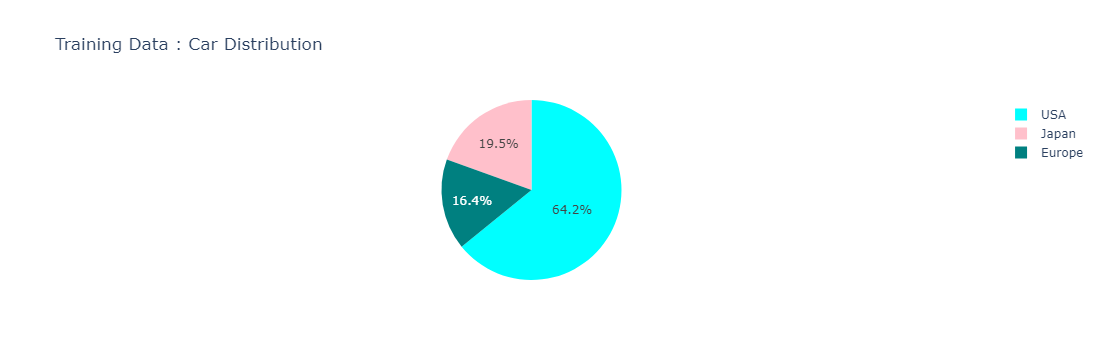

In [13]:
colors = ['aqua', 'pink', 'teal']

trace_train= go.Pie(labels = train_continet_car_count.index,
              values = train_continet_car_count.values, marker=dict(colors=colors))

layout = go.Layout(title = "Training Data : Car Distribution")
data = [trace_train]
fig = go.Figure(data=data, layout=layout)
fig.show()

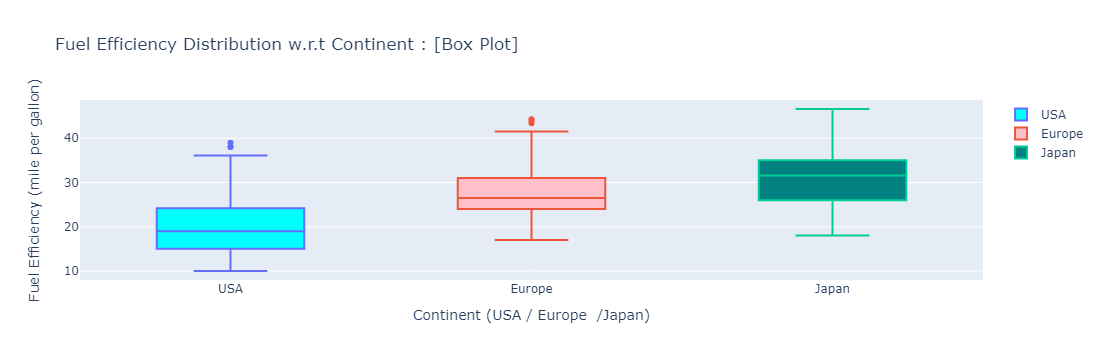

In [14]:
usa = working_dataset[working_dataset["Continent"]=="USA"]
europe = working_dataset[working_dataset["Continent"]=="Europe"]
japan = working_dataset[working_dataset["Continent"]=="Japan"]

trace = go.Box(y = usa["mpg"],fillcolor="aqua", name= "USA" )
trace1 = go.Box(y = europe["mpg"], fillcolor="pink", name= "Europe" )
trace2 = go.Box(y = japan["mpg"], fillcolor="teal", name= "Japan" )

layout = go.Layout(title="Fuel Efficiency Distribution w.r.t Continent : [Box Plot]", 
                   yaxis=dict(title="Fuel Efficiency (mile per gallon)"), 
                   xaxis= dict(title="Continent (USA / Europe  /Japan)"))

data=[trace, trace1, trace2]
fig = go.Figure(data = data, layout=layout)
fig.show()

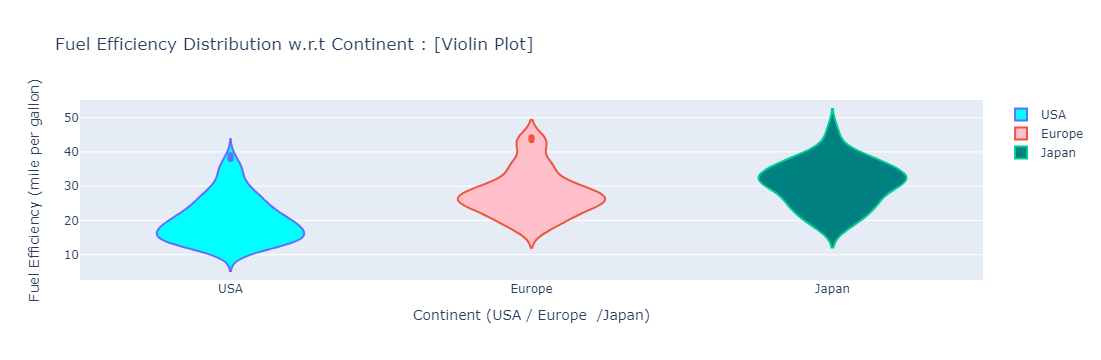

In [15]:
trace1 = go.Violin( y = usa["mpg"], fillcolor="aqua", name="USA")
trace2 = go.Violin( y = europe["mpg"],fillcolor="pink", name="Europe")
trace3 = go.Violin( y = japan["mpg"],fillcolor="teal", name="Japan")

layout = go.Layout(title="Fuel Efficiency Distribution w.r.t Continent : [Violin Plot]", 
                   yaxis=dict(title="Fuel Efficiency (mile per gallon)"), 
                   xaxis= dict(title="Continent (USA / Europe  /Japan)"))

data=[trace1, trace2, trace3]
fig = go.Figure(data = data, layout=layout)
fig.show()

322    46.6
329    44.6
325    44.3
394    44.0
326    43.4
309    41.5
330    40.9
324    40.8
247    39.4
344    39.0
310    38.1
385    38.0
383    38.0
387    38.0
378    38.0
Name: mpg, dtype: float64


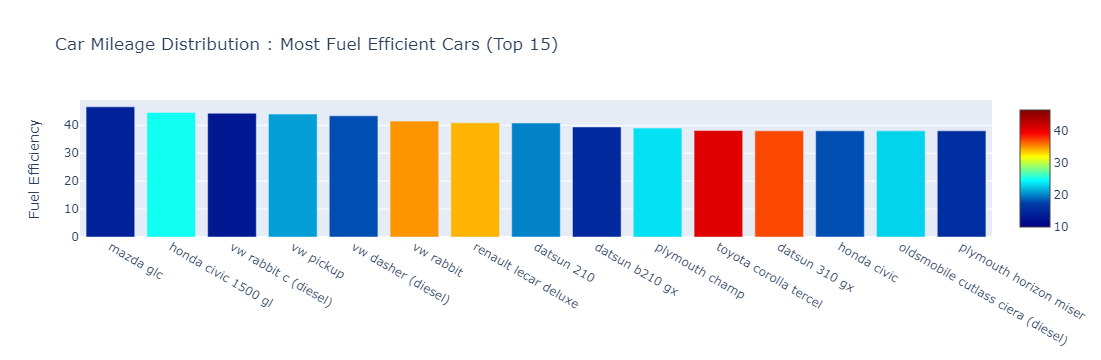

In [16]:
top_fifteen_train_dataset = working_dataset.nlargest(15, 'mpg')
train_car_names = top_fifteen_train_dataset["car name"].dropna()
train_car_mileage = top_fifteen_train_dataset["mpg"].dropna()
print(train_car_mileage)
trace = go.Bar(x = train_car_names,
              y = train_car_mileage, 
              marker = dict(color = train_dataset["mpg"],
                           colorscale = "Jet", 
                           showscale = True))
layout = go.Layout(title = "Car Mileage Distribution : Most Fuel Efficient Cars (Top 15)", 
                  yaxis = dict(title = "Fuel Efficiency"))
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

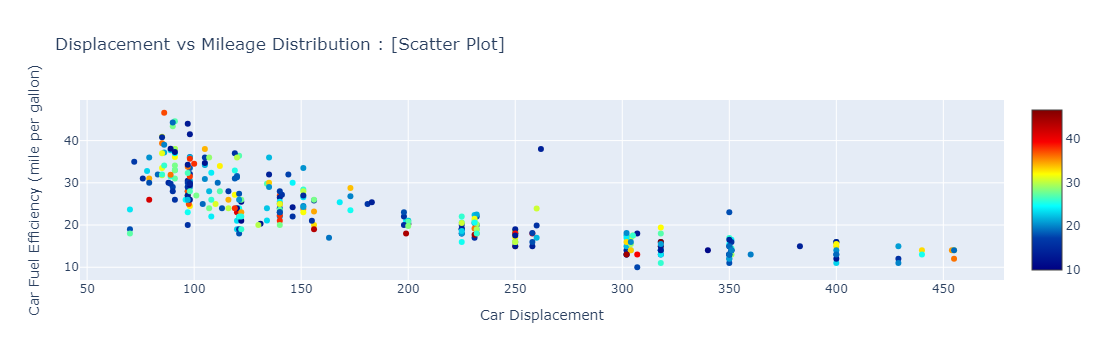

In [17]:
train_displacements = working_dataset["displacement"].dropna()
trace = go.Scatter(x = train_displacements, y = working_dataset["mpg"].dropna(), 
              mode = 'markers',                 
              marker = dict(color = train_dataset["mpg"],
                           colorscale = "Jet", 
                           showscale = True))
layout = go.Layout(title = "Displacement vs Mileage Distribution : [Scatter Plot]", 
                  xaxis = dict(title = 'Car Displacement'), 
                  yaxis = dict(title = 'Car Fuel Efficiency (mile per gallon)'))
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

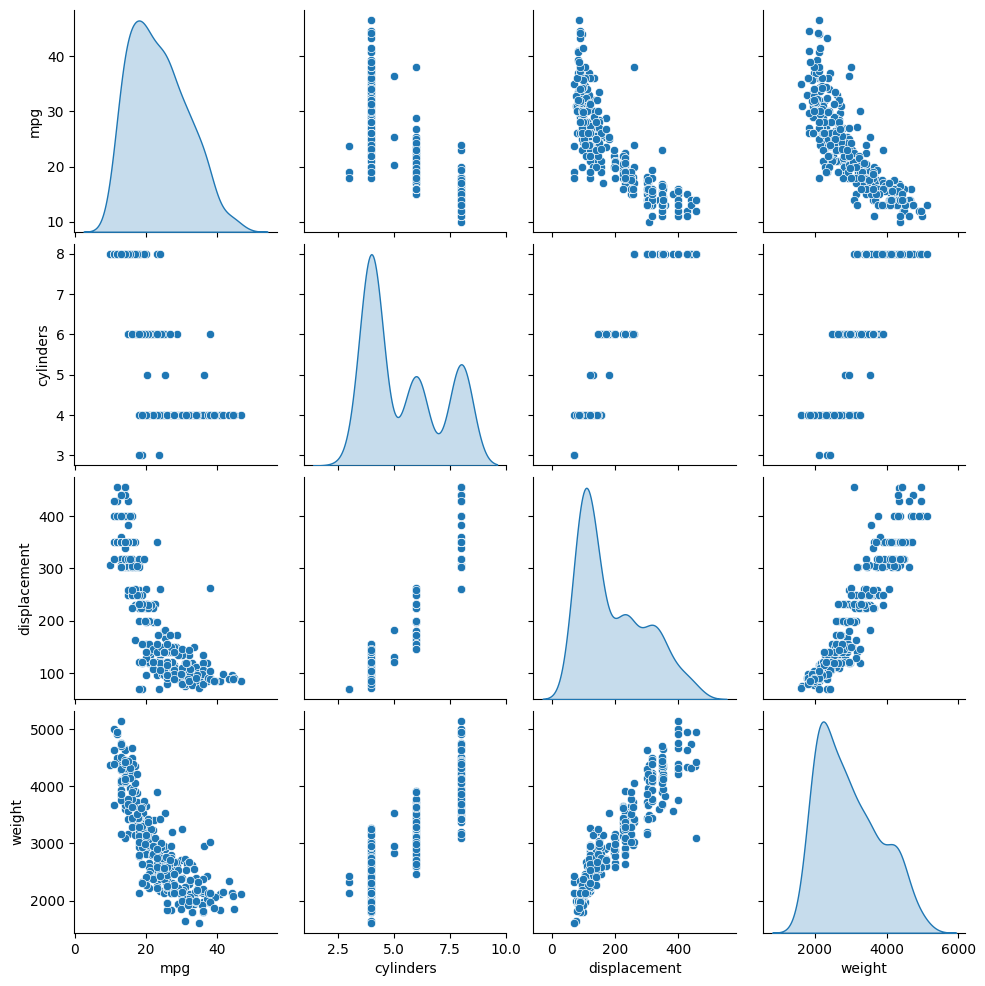

In [18]:
sns.pairplot(working_dataset[["mpg", "cylinders", "displacement", "weight"]], diag_kind="kde")

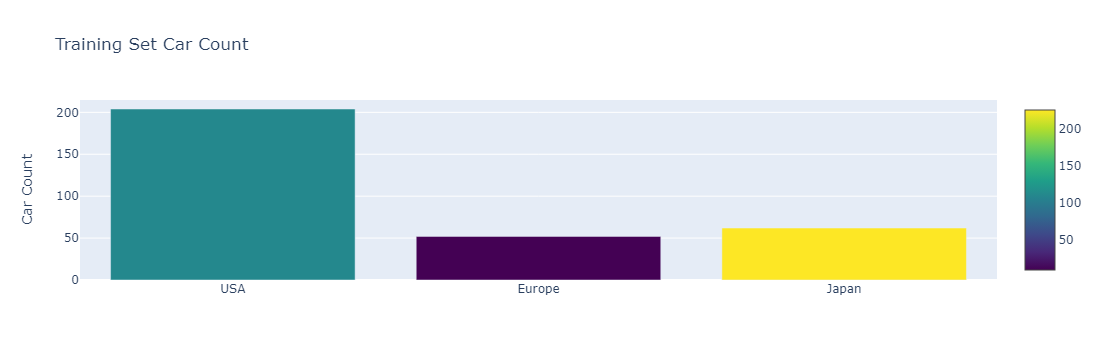

In [19]:
trace = go.Bar(x = ['USA', 'Europe', 'Japan'],
              y = [usa['mpg'].count(),europe['mpg'].count(), japan['mpg'].count()], 
              marker = dict(color = [111, 10, 225, 175],
                           colorscale = "Viridis", 
                           showscale = True))
layout = go.Layout(title = "Training Set Car Count ", 
                  yaxis = dict(title = "Car Count"))
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

In [20]:
train_stats = train_dataset.describe()
train_stats.pop("mpg")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
cylinders,318.0,5.427673,1.682941,3.0,4.00,4.0,6.00,8.0
displacement,318.0,193.061321,103.812742,70.0,100.25,151.0,259.50,455.0
weight,318.0,2963.823899,844.749805,1613.0,2219.25,2792.5,3571.25,5140.0
acceleration,318.0,15.595912,2.796282,8.0,13.90,15.5,17.30,24.8
model year,318.0,75.946541,3.705266,70.0,73.00,76.0,79.00,82.0
USA,318.0,0.641509,0.480313,0.0,0.00,1.0,1.00,1.0
Europe,318.0,0.163522,0.370424,0.0,0.00,0.0,0.00,1.0
Japan,318.0,0.194969,0.396801,0.0,0.00,0.0,0.00,1.0


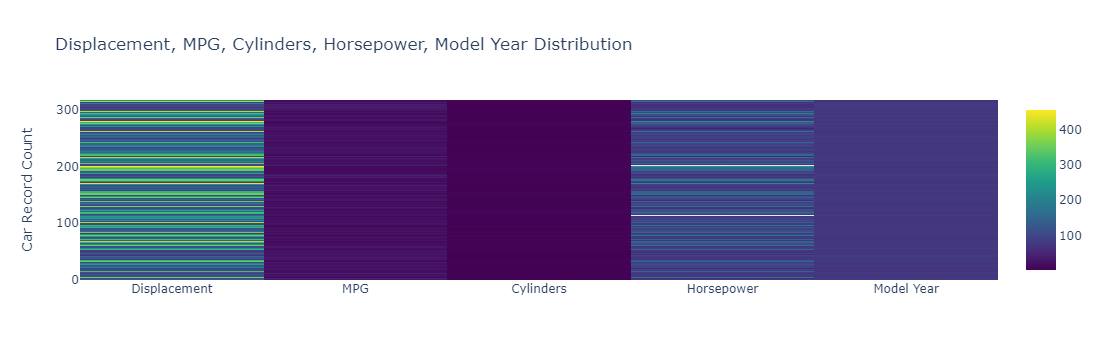

In [21]:
trace = go.Heatmap(z=working_dataset[["displacement", "mpg", "cylinders", "horsepower", "model year"]].dropna().values,
                   x=['Displacement', 'MPG', 'Cylinders', 'Horsepower', 'Model Year'],
#                    y=['USA', 'Europe', 'Japan'],
                   colorscale = 'Viridis')
#                    y=["USA", "Europe", "Japan"])
layout = go.Layout(title = "Displacement, MPG, Cylinders, Horsepower, Model Year Distribution",
                  yaxis = dict(title = "Car Record Count"))
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

## Data preparation for plotting charts


In [22]:
df = working_dataset.copy()
df['Origin'] = np.where(df['Continent'] == 'USA', 1,
                                np.where(df['Continent'] == 'Europe', 2, 3))
df.tail()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,car name,USA,Europe,Japan,Continent,Origin
344,39.0,4,86.0,64,1875,16.4,81,plymouth champ,1.0,0.0,0.0,USA,1
33,19.0,6,232.0,100,2634,13.0,71,amc gremlin,1.0,0.0,0.0,USA,1
44,13.0,8,400.0,175,5140,12.0,71,pontiac safari (sw),1.0,0.0,0.0,USA,1
112,19.0,4,122.0,85,2310,18.5,73,ford pinto,1.0,0.0,0.0,USA,1
37,18.0,6,232.0,100,3288,15.5,71,amc matador,1.0,0.0,0.0,USA,1


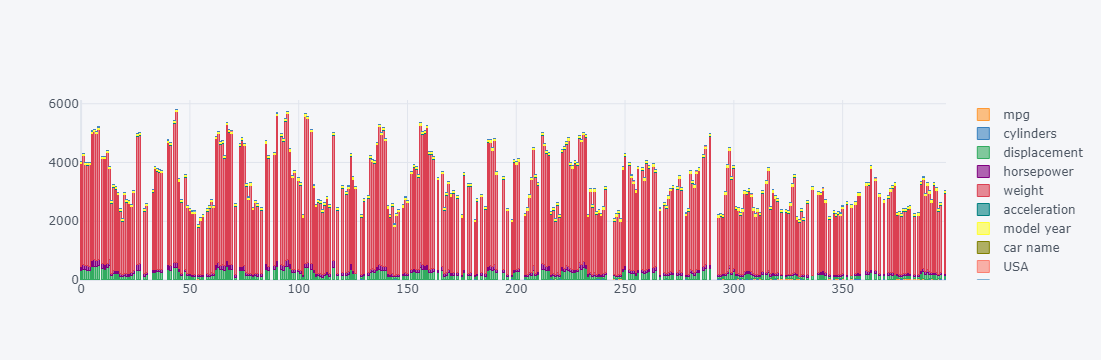

In [23]:
df.iplot(kind='bar', barmode='stack', filename='cufflinks/grouped-bar-chart')

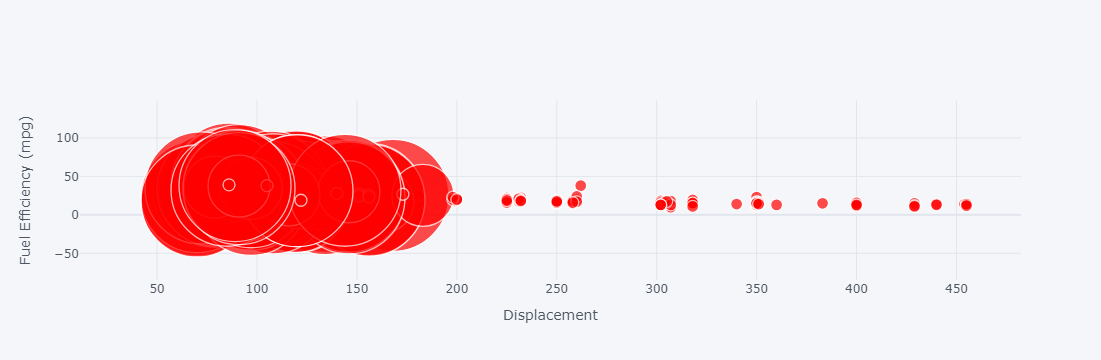

In [24]:
df.iplot(kind='bubble', x='displacement', y='mpg', size='Origin', text='Continent',
             xTitle='Displacement', yTitle='Fuel Efficiency (mpg)', colors='rgb(255,0,0)', 
             filename='simple-bubble-chart') # Bubble Chart

## Split features from labels

In [25]:
train_labels = train_dataset.pop('mpg')
test_labels = test_dataset.pop('mpg')
train_dataset.tail()

,cylinders,displacement,horsepower,weight,acceleration,model year,USA,Europe,Japan
207,4,130.0,102,3150,15.7,76,0.0,1.0,0.0
279,4,98.0,68,2135,16.6,78,0.0,0.0,1.0
227,6,225.0,100,3630,17.7,77,1.0,0.0,0.0
148,4,116.0,75,2246,14.0,74,0.0,1.0,0.0
143,4,97.0,78,2300,14.5,74,0.0,1.0,0.0


## Normalize the data

In [26]:
train_dataset.dropna()
test_dataset.dropna()

train_dataset.pop('horsepower')
test_dataset.pop('horsepower')

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## Build The Model

In [43]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model
model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                576       
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4801 (18.75 KB)
Trainable params: 4801 (18.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 0s 65ms/step


array([[ 0.25086695],
       [-0.44793734],
       [ 0.13003503],
       [-0.17245956],
       [-0.21115647],
       [-0.2530698 ],
       [-0.07992542],
       [-0.43895918],
       [ 0.324273  ],
       [-0.06408741]], dtype=float32)

## Training Model To Predict Fuel Efficiency

In [45]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

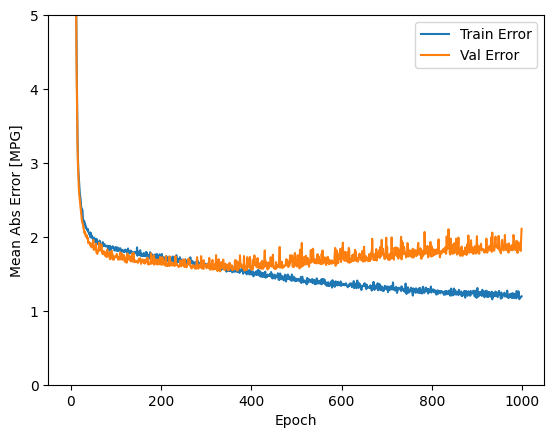

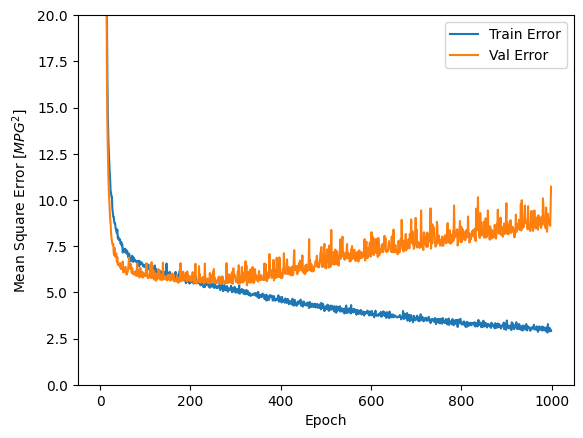

In [30]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()
plot_history(history)


....................................................................................

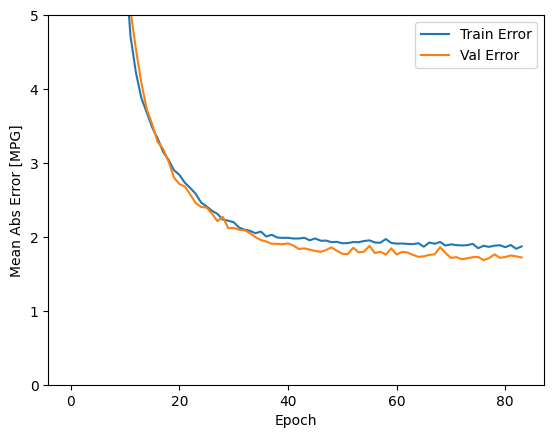

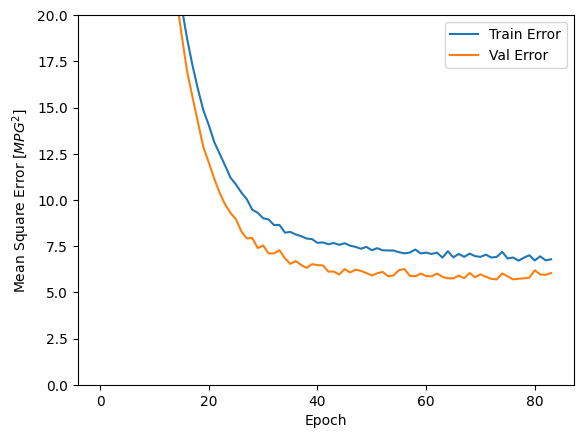

In [31]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [32]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.99 MPG


3/3 [==============================] - 0s 5ms/step


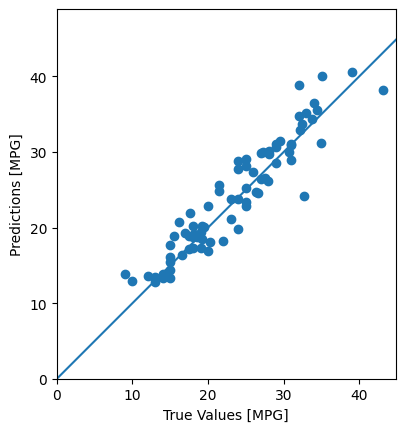

In [33]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

## Scikit Learn Modeling

In [34]:
columns = normed_train_data.columns
column_test = normed_test_data.columns
y_train = train_labels.copy()

lab_enc = preprocessing.LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y_train)

scaler = preprocessing.Normalizer()
X_train = scaler.fit_transform(normed_train_data)
X_train = pd.DataFrame(X_train, columns=columns)

X_test = scaler.transform(normed_test_data)
X_test = pd.DataFrame(X_test, columns=column_test)

In [35]:
lin = LinearRegression()
lin.fit(X_train, y_train_encoded)

pred_lin = lin.predict(X_test)
lin.score(X_train, y_train_encoded)
linear_score = round(lin.score(X_train, y_train_encoded)*100,2)
linear_score

81.39

## Logistic Regression

In [36]:
log = LogisticRegression()
log.fit(X_train, y_train_encoded)

pred_log = log.predict(X_test)

log.score(X_train, y_train_encoded)
logistic_score = round(log.score(X_train, y_train_encoded)*100,2)
logistic_score

16.35

## RandomForestClassifier(RF Model)

In [37]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train_encoded)
pred_random = rf.predict(X_test)

rf.score(X_train, y_train_encoded)

random_score = round(rf.score(X_train, y_train_encoded)*100,2)
random_score

100.0

## DecisionTreeClassifier (DT Model)

In [38]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train_encoded)

pred_tree = tree.predict(X_test)

tree.score(X_train, y_train_encoded)
tree_score = round(tree.score(X_train, y_train_encoded)*100,2)
tree_score

100.0

## KNeighborsClassifier (KNN Model)

In [39]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train_encoded)
pred_knn = knn.predict(X_test)

knn.score(X_train, y_train_encoded)
knn_score = round(knn.score(X_train, y_train_encoded)*100,2)
knn_score

100.0

## GaussianNB (Gaussian Naive Bayes)

In [40]:
gaus = GaussianNB()
gaus.fit(X_train, y_train_encoded)
pred_gaus = gaus.predict(X_test)

gaus.score(X_train, y_train_encoded)
gaus_score = round(gaus.score(X_train, y_train_encoded)*100,2)
gaus_score

54.09

In [41]:
df_score = pd.DataFrame({"Models": ['KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Decision Tree', 'Linear Regression'], 
                       "Score": [knn_score, logistic_score, random_score, gaus_score, 
                                 tree_score, linear_score]})
df_score.sort_values(by= "Score", ascending=False)

,Models,Score
0,KNN,100.00
2,Random Forest,100.00
4,Decision Tree,100.00
5,Linear Regression,81.39
3,Naive Bayes,54.09
1,Logistic Regression,16.35
